In [136]:
#Data Driven Project
#Camilla Tagliabue
#Michele Scotti

In [137]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [138]:
#now let's define the required functions

In [139]:
#to read a file 
def read_file(file_name):
    data_set = pd.read_csv(file_name,sep=',',index_col=0)
    desired_index = data_set.index
    datetime_index = pd.to_datetime(desired_index)
    data_set.index = datetime_index
    return data_set
#to normalize datas
def normalize(df):
    return (df - df.min())/(df.max()-df.min())
#if it's Saturday or Sunday this function returns 1 otherwise it returns 0 
def weekend_detector(day):
    if (day==5 or day==6):
        weekend = 1
    else:
        weekend = 0
    return weekend
#the aim it's to include previous values into current row
def lag_column(df,column_names,lag_times=1):
    for column_name in column_names:
        column_name = str(column_name)
        for i in np.arange(6,lag_times+1,1):
            new_column_name = column_name+'_'+str(i)+'hour'
            df[new_column_name]=(df[column_name]).shift(i)
    return df

In [140]:
dataframe = read_file("D:\Michele\Universita\Building systems\Progetto\Project\Python Part\energydata_complete.csv")
dataframe.head()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
date,,,,,,,,,,,,,,,,,,,,,
2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,...,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,...,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,...,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,...,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,...,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


In [141]:
dataframe['hour'] = dataframe.index.hour #creating hour column in the framework
dataframe['day_of_week'] = dataframe.index.dayofweek #creating day of the week column in the framework
dataframe['month'] = dataframe.index.month 
dataframe['day_night'] = [1 if day<20 and day>9 else 0 for day in dataframe.index.hour ]

In [142]:
#we create a new column of 1 - to indicate days of the week - and 0 - for weekends
dataframe['weekend'] = [weekend_detector(s) for s in dataframe['day_of_week']]

In [143]:
df_lagged = lag_column(dataframe,['Appliances'],lag_times=6*10)
df_lagged = lag_column(df_lagged,['T_out'],lag_times=4)
df_lagged = lag_column(df_lagged,['RH_out'],lag_times=4)
df_lagged.dropna(inplace=True)

In [144]:
dataframe = dataframe.dropna() #to eliminate NaN rows 

# remove outliers
dataframe = dataframe.loc[(dataframe['Appliances']<400)]

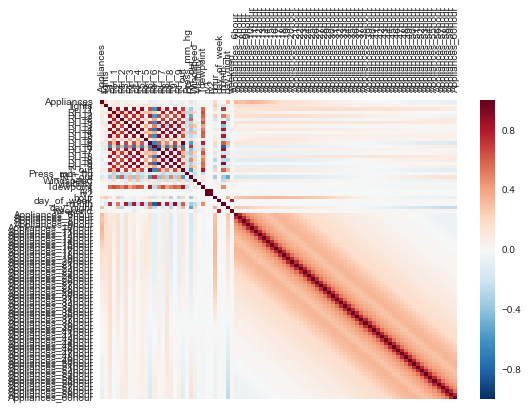

In [145]:
#let's create a heat map of the datas, it helps us to understand between which variables there is correlation and between which one there isn't
fig = plt.figure()
plot = fig.add_axes()
plot = sns.heatmap(df_lagged.dropna().corr(), annot=False)
plot.xaxis.tick_top() 
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.show()

In [146]:
#let's define target and feature to check if there's a correlation btw variables
target = dataframe[['Appliances']]
features = dataframe[[col for col in dataframe.columns if col not in ['Appliances']]]

In [147]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=123524)

from sklearn import linear_model
linear_reg = linear_model.LinearRegression()

linear_reg.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

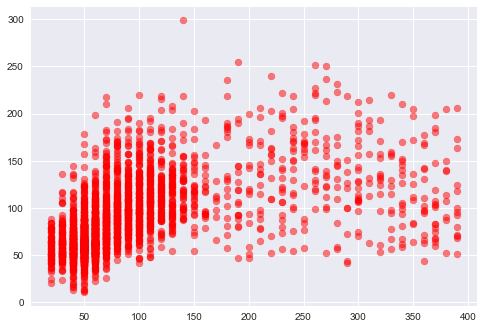

In [148]:
prediction = linear_reg.predict(X_test)

predict_series = pd.Series(prediction.ravel(),index=y_test.index).rename('Prediction appliance')
joined = pd.DataFrame(predict_series).join(y_test).dropna()


plt.scatter(joined['Appliances'],joined['Prediction appliance'],color = 'r', alpha=0.5)
plt.show()

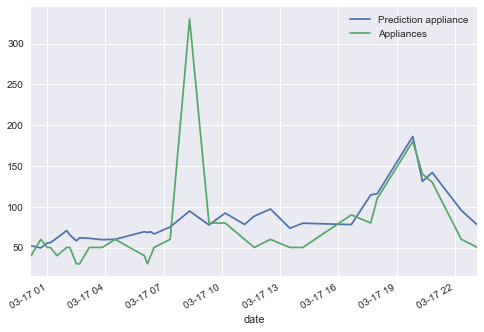

In [149]:

joined['2016-03-17'].plot()
plt.show()

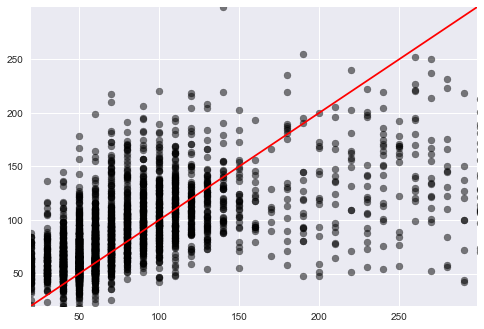

In [150]:
lineStart = joined['Appliances'].min() 
lineEnd = joined['Prediction appliance'].max()  
plt.scatter(joined['Appliances'],joined['Prediction appliance'], color = 'k', alpha=0.5)
plt.plot([lineStart, lineEnd], [lineStart, lineEnd], 'k-', color = 'r')
plt.xlim(lineStart, lineEnd)
plt.ylim(lineStart, lineEnd)
plt.show()

In [151]:
from sklearn.metrics import r2_score
r2_score(joined['Appliances'],joined['Prediction appliance'])


0.29240792945914307

In [152]:
#the r2 value is very low, therefore there isn't a good correlation between target and features